In [22]:
#Python Default 

import pickle
import time
import random

#Essentials

import numpy as np
from bs4 import BeautifulSoup
import requests
import func_timeout
import pandas as pd

#from objproxies import *

import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

#Qiskit

from qiskit.circuit import Gate
from qiskit.circuit.library import *
from qiskit import transpile
from qiskit.providers.models import *
from qiskit_ibm_runtime.fake_provider import *
from qiskit.providers.fake_provider import *

## Qiskit Nature
    
from qiskit_nature.units import *   #ANGSTROM

from qiskit_nature.second_q.drivers import *    #PySCFDriver

from qiskit_nature.second_q.mappers import * #JordanWignerMapper

from qiskit_nature.second_q.algorithms import GroundStateEigensolver

from qiskit_nature.second_q.problems import ElectronicStructureProblem

from qiskit_nature.second_q.circuit.library import *  #Ansatz, HF

## Qiskit Algorithms
    
from qiskit_algorithms.minimum_eigensolvers import VQE as  VQE_algorithms   #VQE
 
from qiskit_algorithms.optimizers import *    #SLSQP

from qiskit.circuit.library import EfficientSU2   #EfficientSU2

## Qiskit Primitives

from qiskit.primitives import Estimator as Estimator_Nature

from qiskit_aer.primitives.estimator import Estimator as Estimator_Aer

## Qiskit Noise Models

from qiskit_aer.noise import NoiseModel

from qiskit.providers.fake_provider import *

##Qiskit Runtime IBM

from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options

from qiskit_ibm_runtime import Estimator, EstimatorV2    #Estimator

## Braket

from braket.tracking import Tracker
from qiskit_braket_provider import *


%matplotlib widget

In [2]:
provider = BraketProvider()
local_simulator = BraketLocalBackend()
sv1_simualtor = provider.get_backend("SV1")

In [3]:
service = QiskitRuntimeService()
backend = service.backend("ibm_brisbane")
noise_model = NoiseModel.from_backend(backend)
coupling_map = backend.configuration().coupling_map

In [4]:
driver = PySCFDriver(
    atom= f"H 0 0 0; H 0 0 1",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

es_problem = driver.run()

#estimator = Estimator(backend = local_simulator, options={"shots" : 2000, "noise_model" : noise_model, "coupling_map" : coupling_map})

estimator = Estimator(backend = local_simulator)


mapper = JordanWignerMapper()

ansatz = UCCSD(
    es_problem.num_spatial_orbitals,
    es_problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        es_problem.num_spatial_orbitals,
        es_problem.num_particles,
        mapper,
    ),
)

vqe_solver = VQE_algorithms(estimator, ansatz, COBYLA())

vqe_solver.initial_point = [0.0] * ansatz.num_parameters

calc = GroundStateEigensolver(mapper, vqe_solver)

minimum_eigenvalue = vqe_solver.compute_minimum_eigenvalue(calc.get_qubit_operators(es_problem)[0])

/var/folders/d4/z_n9lbbn01l5bl2nvfqsf8p80000gq/T/ipykernel_31125/3689711471.py:13: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = local_simulator)


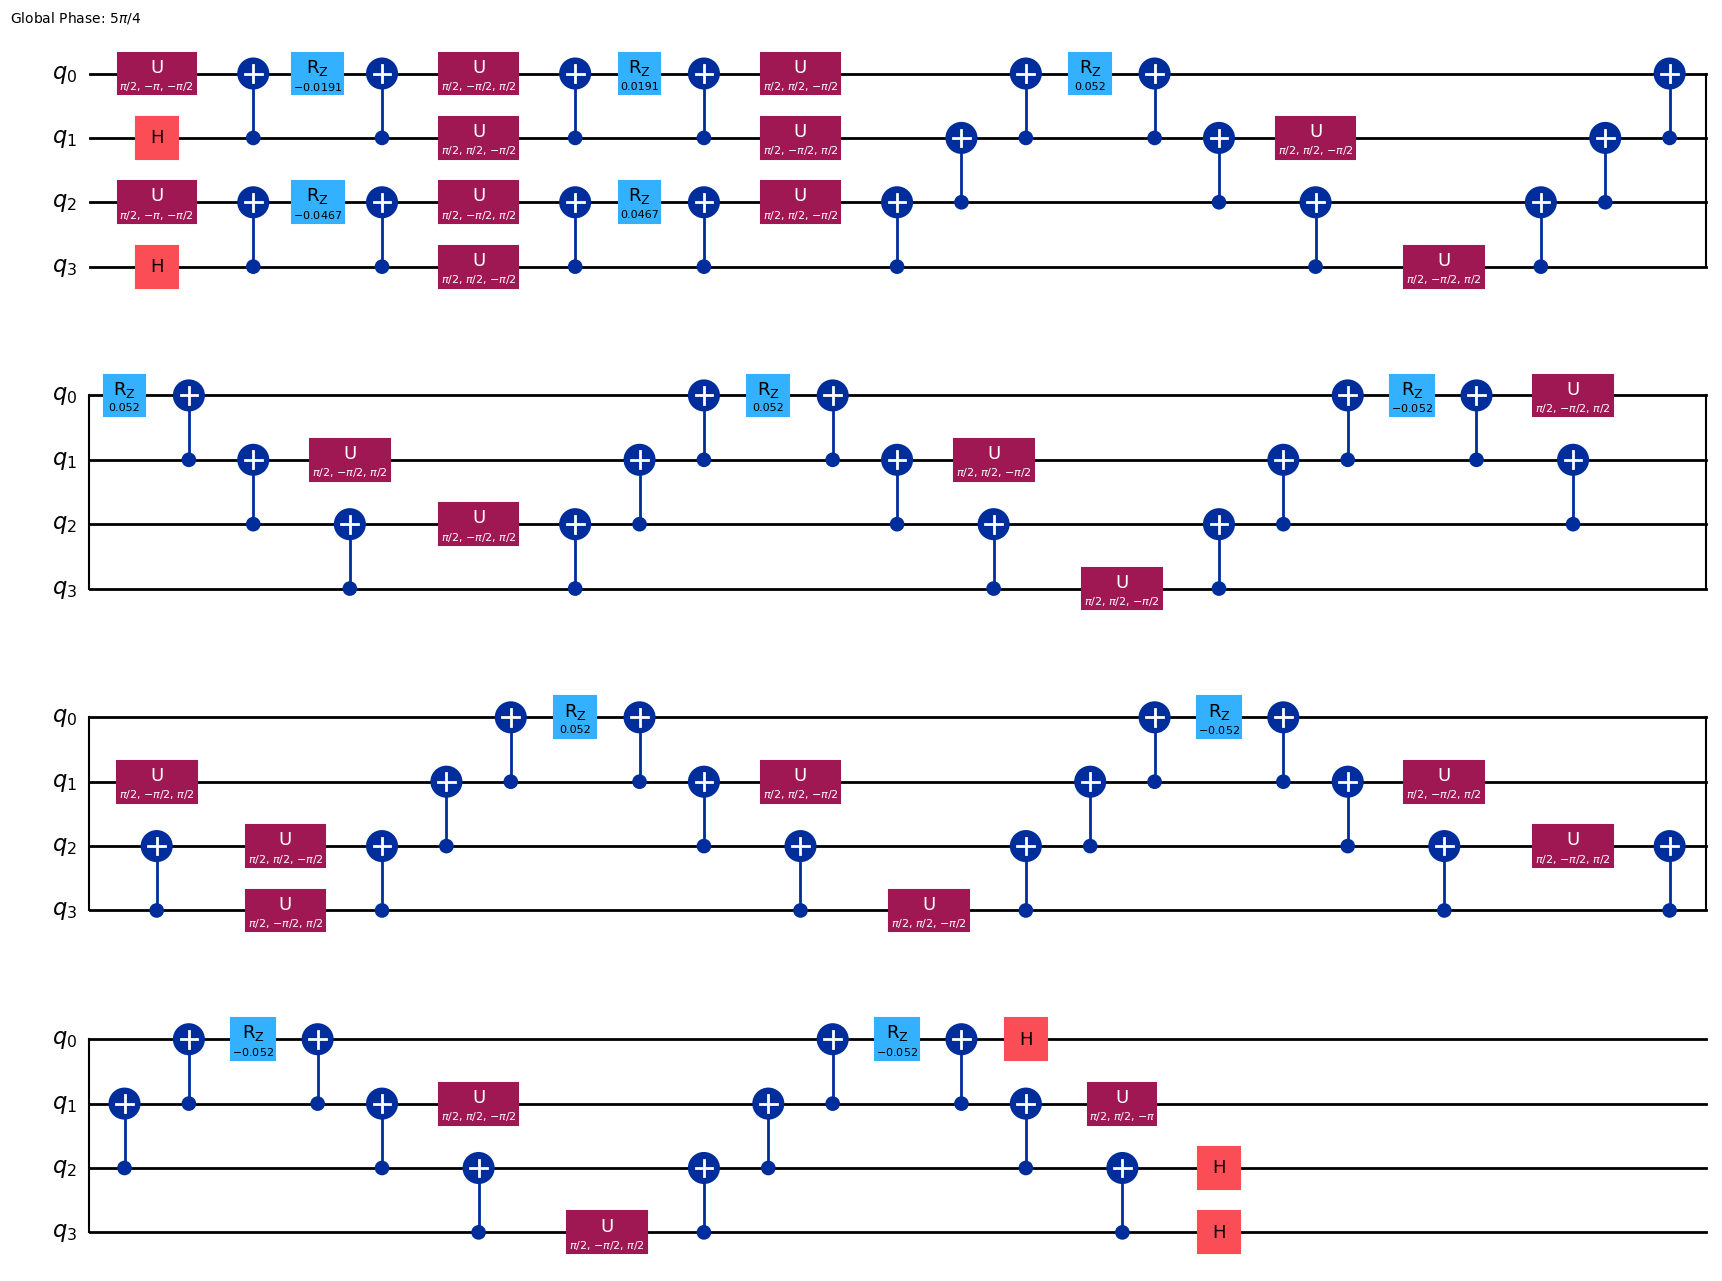

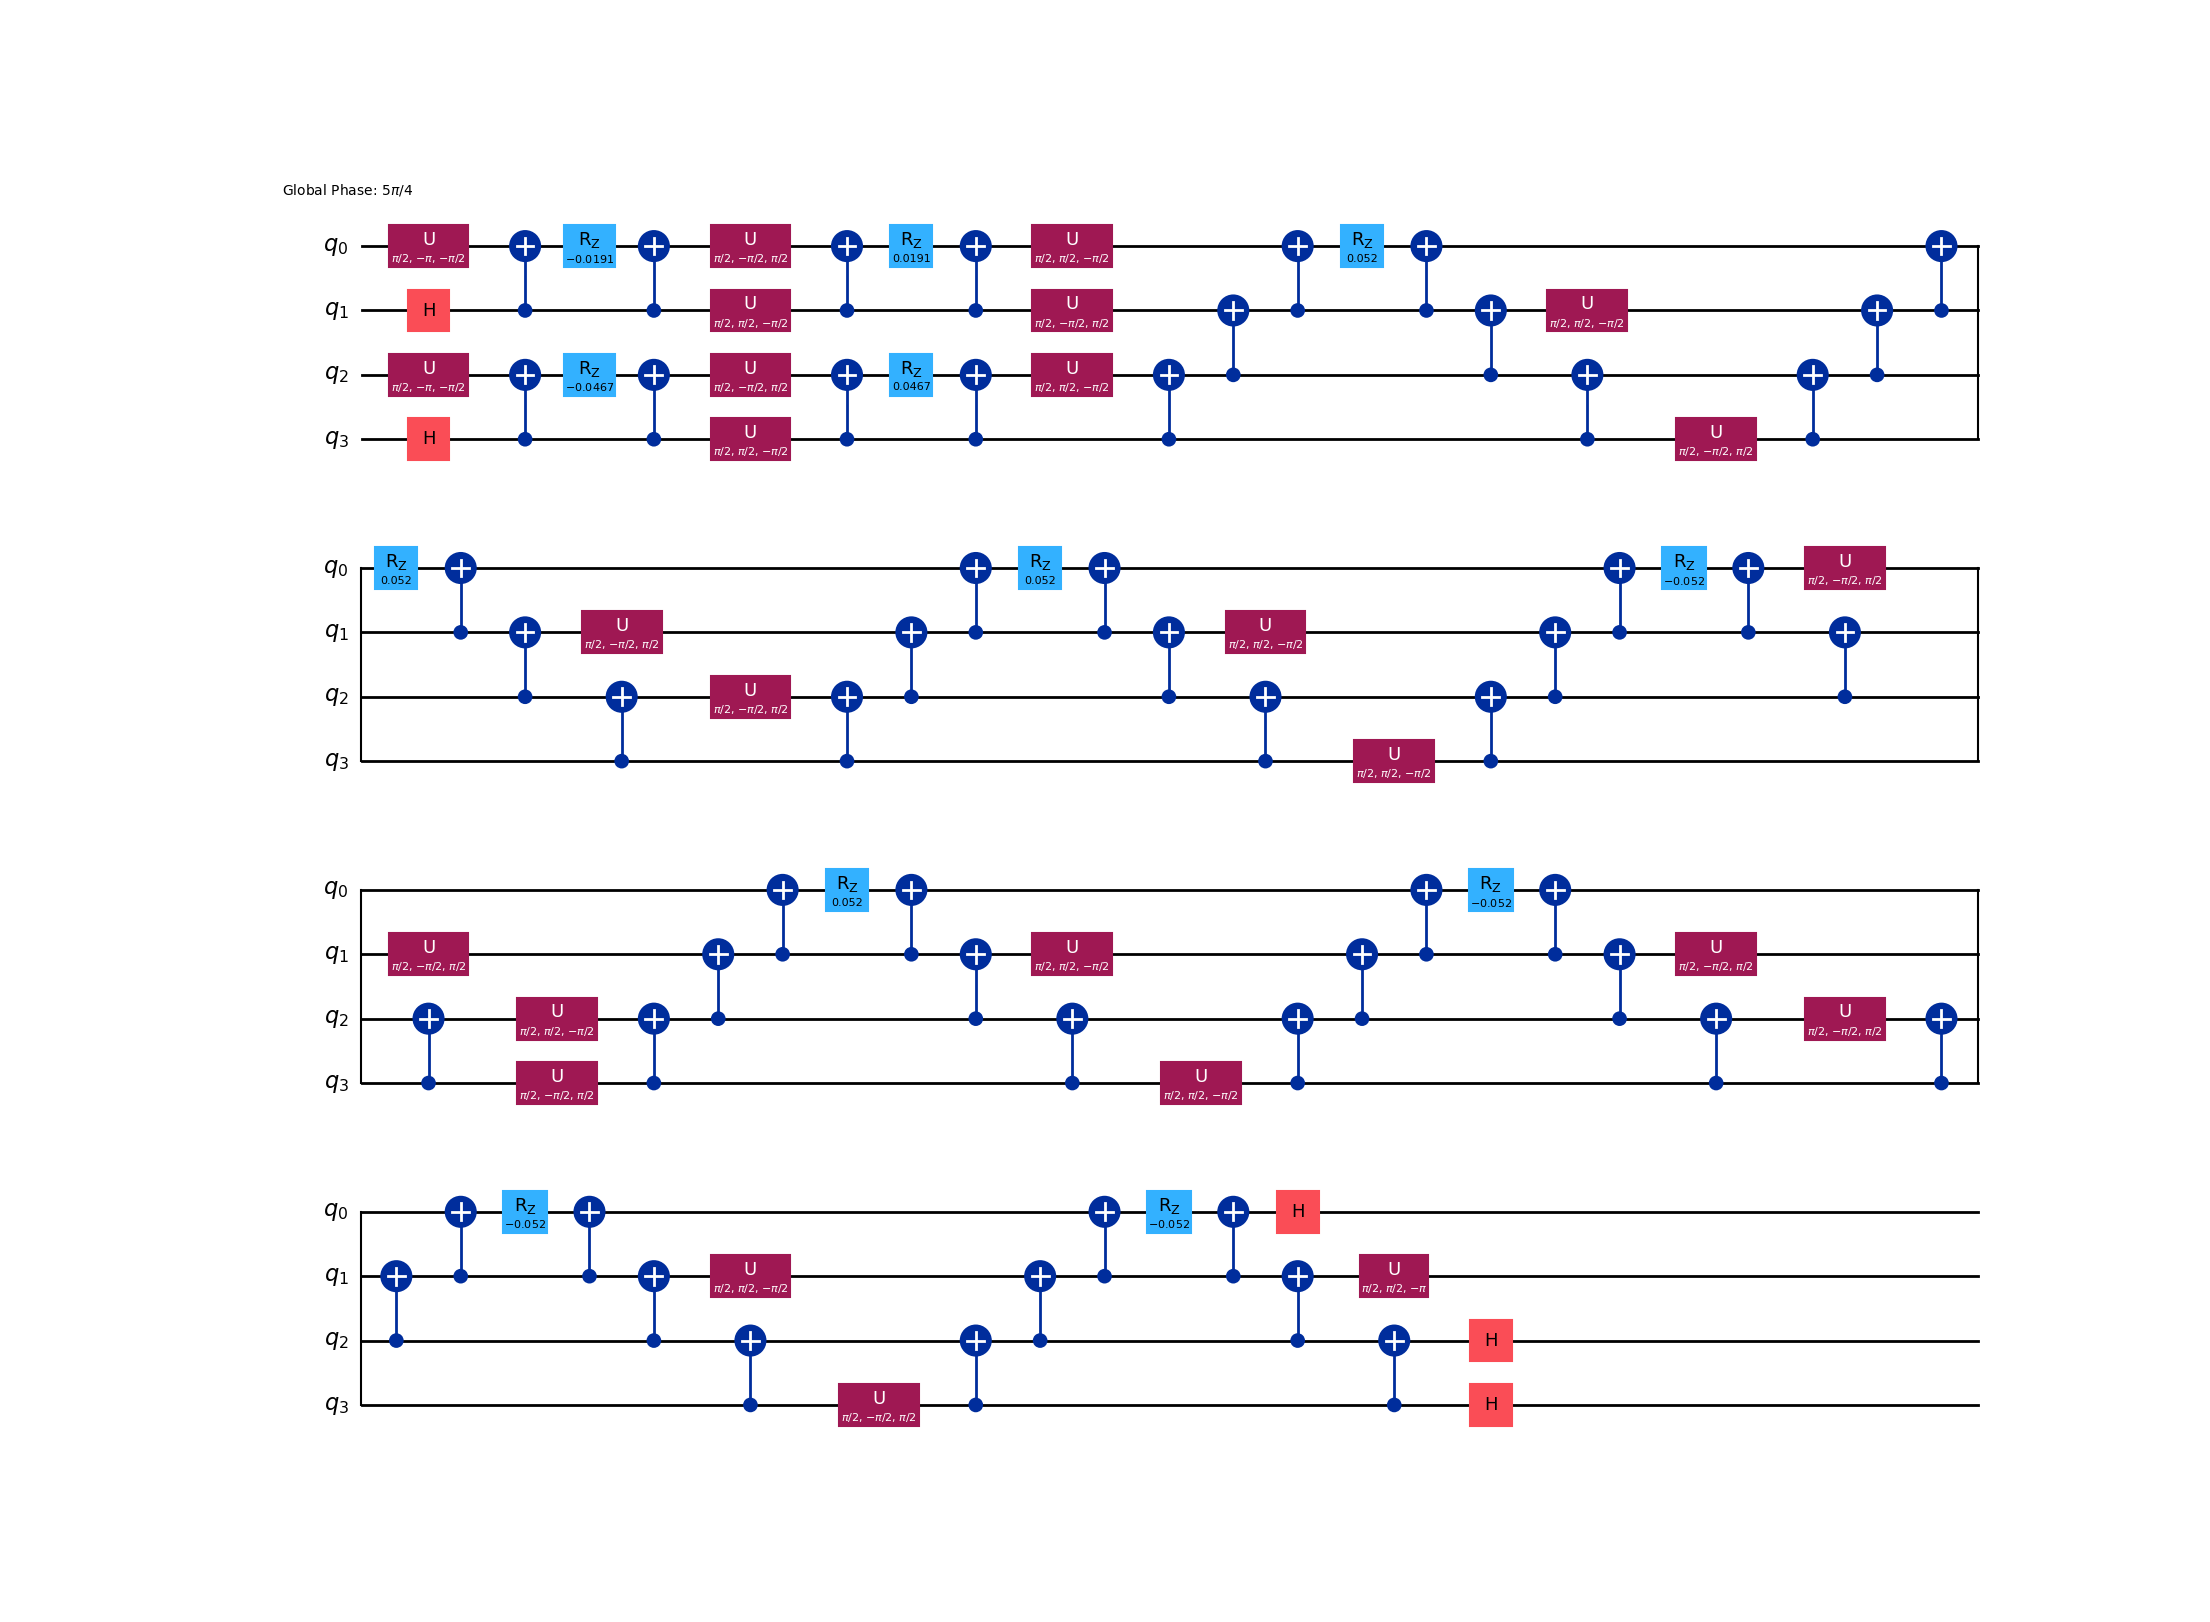

In [12]:
circuito = transpile(minimum_eigenvalue.optimal_circuit.decompose().assign_parameters(minimum_eigenvalue.optimal_parameters), local_simulator)

circuito.draw(output = "mpl")  

In [13]:
gates = []

for i, (gate, qubits, etc) in enumerate(circuito.data):
    
    gates.append(gate.name)

set_gates = list(set(gates))

set_gates.sort(key = lambda x: gates.count(x), reverse = True)

print("Gates present: " + " ".join(set_gates), end = "\n\n")
print(f"Number of gates: {len(gates)}\n\nDistribution of gates: \n")

for i in set_gates:
    
    print(i, gates.count(i))

Gates present: cx u rz h

Number of gates: 99

Distribution of gates: 

cx 56
u 26
rz 12
h 5


In [59]:
def subs_ncg(quantum_circuit, n):
    
   quantum_circuit = quantum_circuit.copy()

   n = n * quantum_circuit.size() // 100

   def clifford_gate():
   
      random_value = random.randint(0, 3)
      
      return RZGate(random_value*np.pi/2)

   non_permitted_gates = ["cx"]

   gates_to_change = random.sample(range(0, quantum_circuit.size()+1), n)

   for i, (gate, *qubits) in enumerate(quantum_circuit.data):
      
      if i in gates_to_change:
      
         if gate.name not in non_permitted_gates:
            
            quantum_circuit.data[i] = (clifford_gate(), *qubits)

         else:
            
            new_gate = random.randint(i, len(quantum_circuit.data)-1)
            
            while quantum_circuit.data[new_gate][0].name in non_permitted_gates or new_gate in gates_to_change:
                
                new_gate = random.randint(i, len(quantum_circuit.data)-1)

            quantum_circuit.data[new_gate] = (clifford_gate(), *quantum_circuit.data[new_gate][1:])

   return quantum_circuit

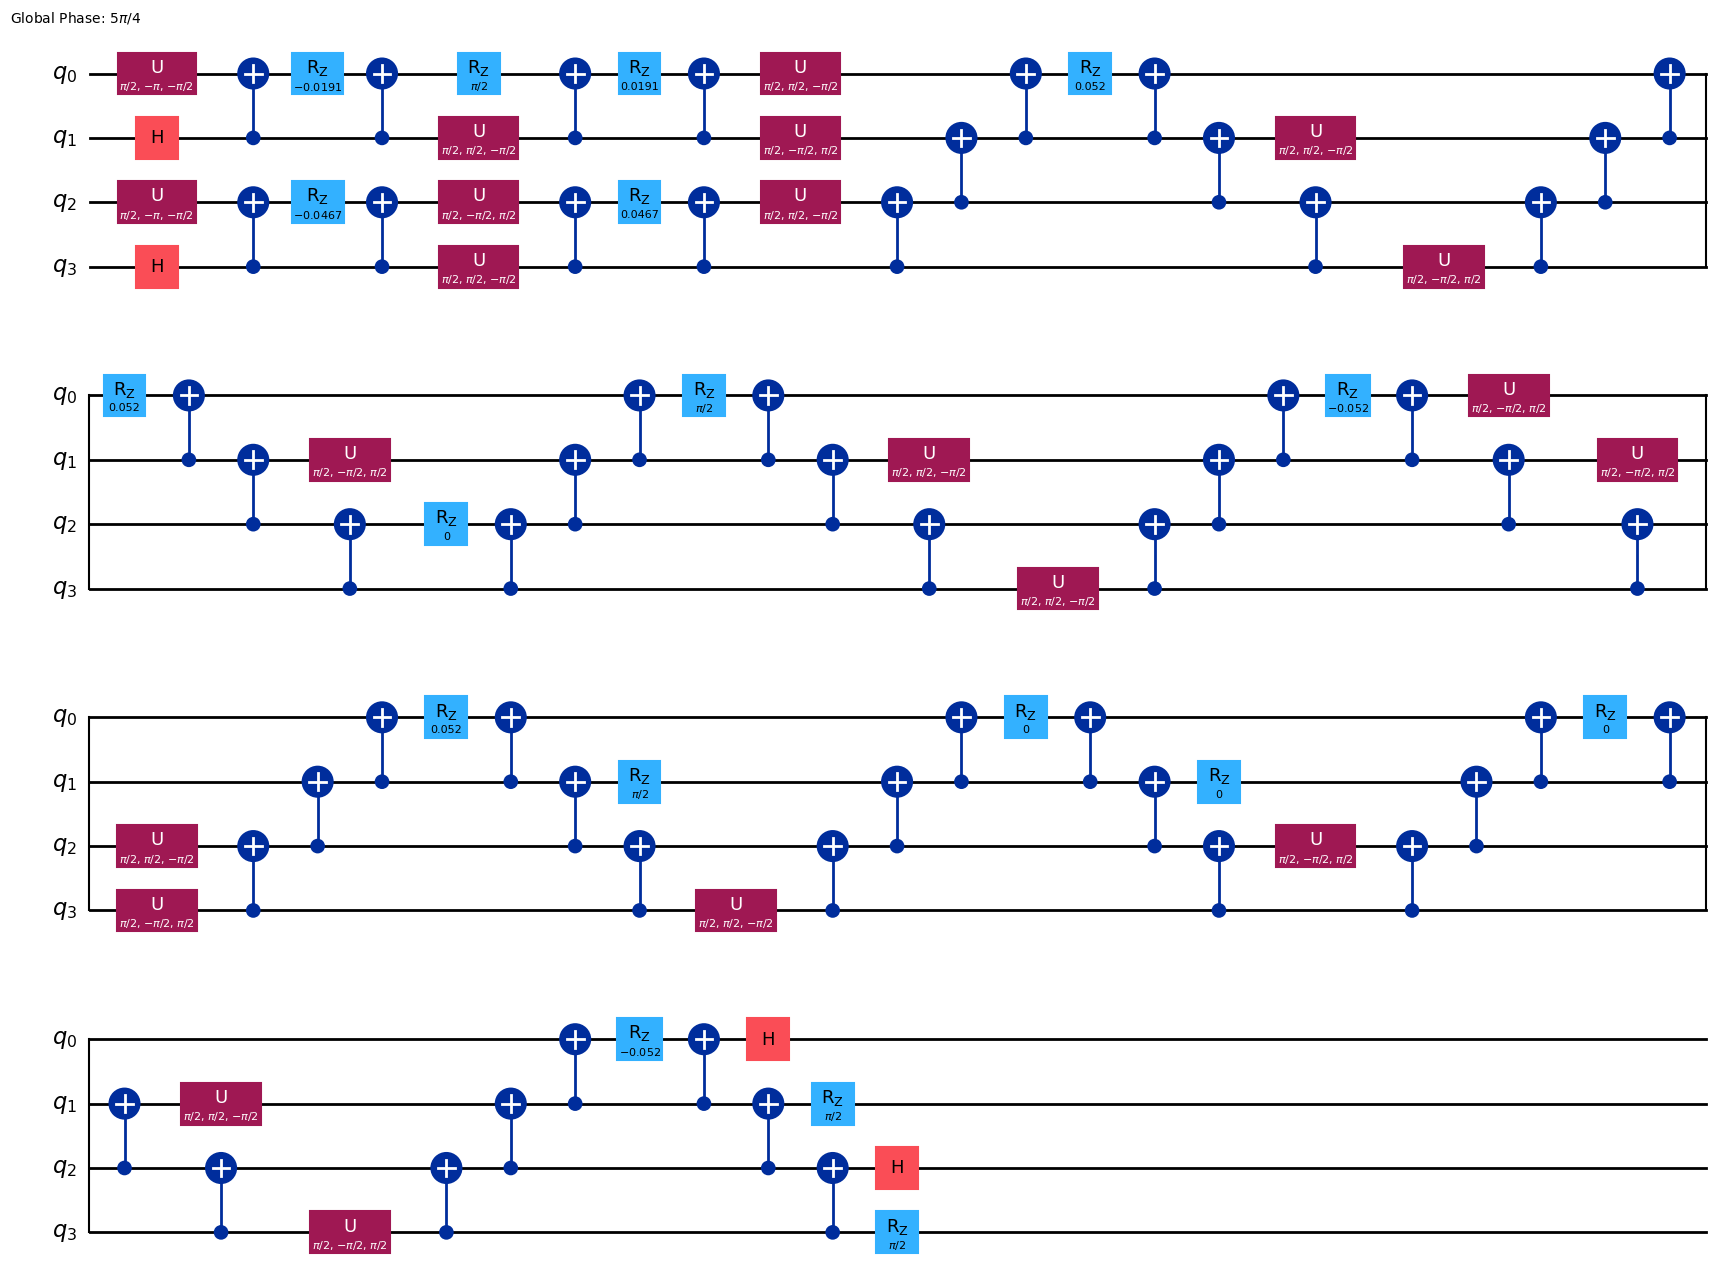

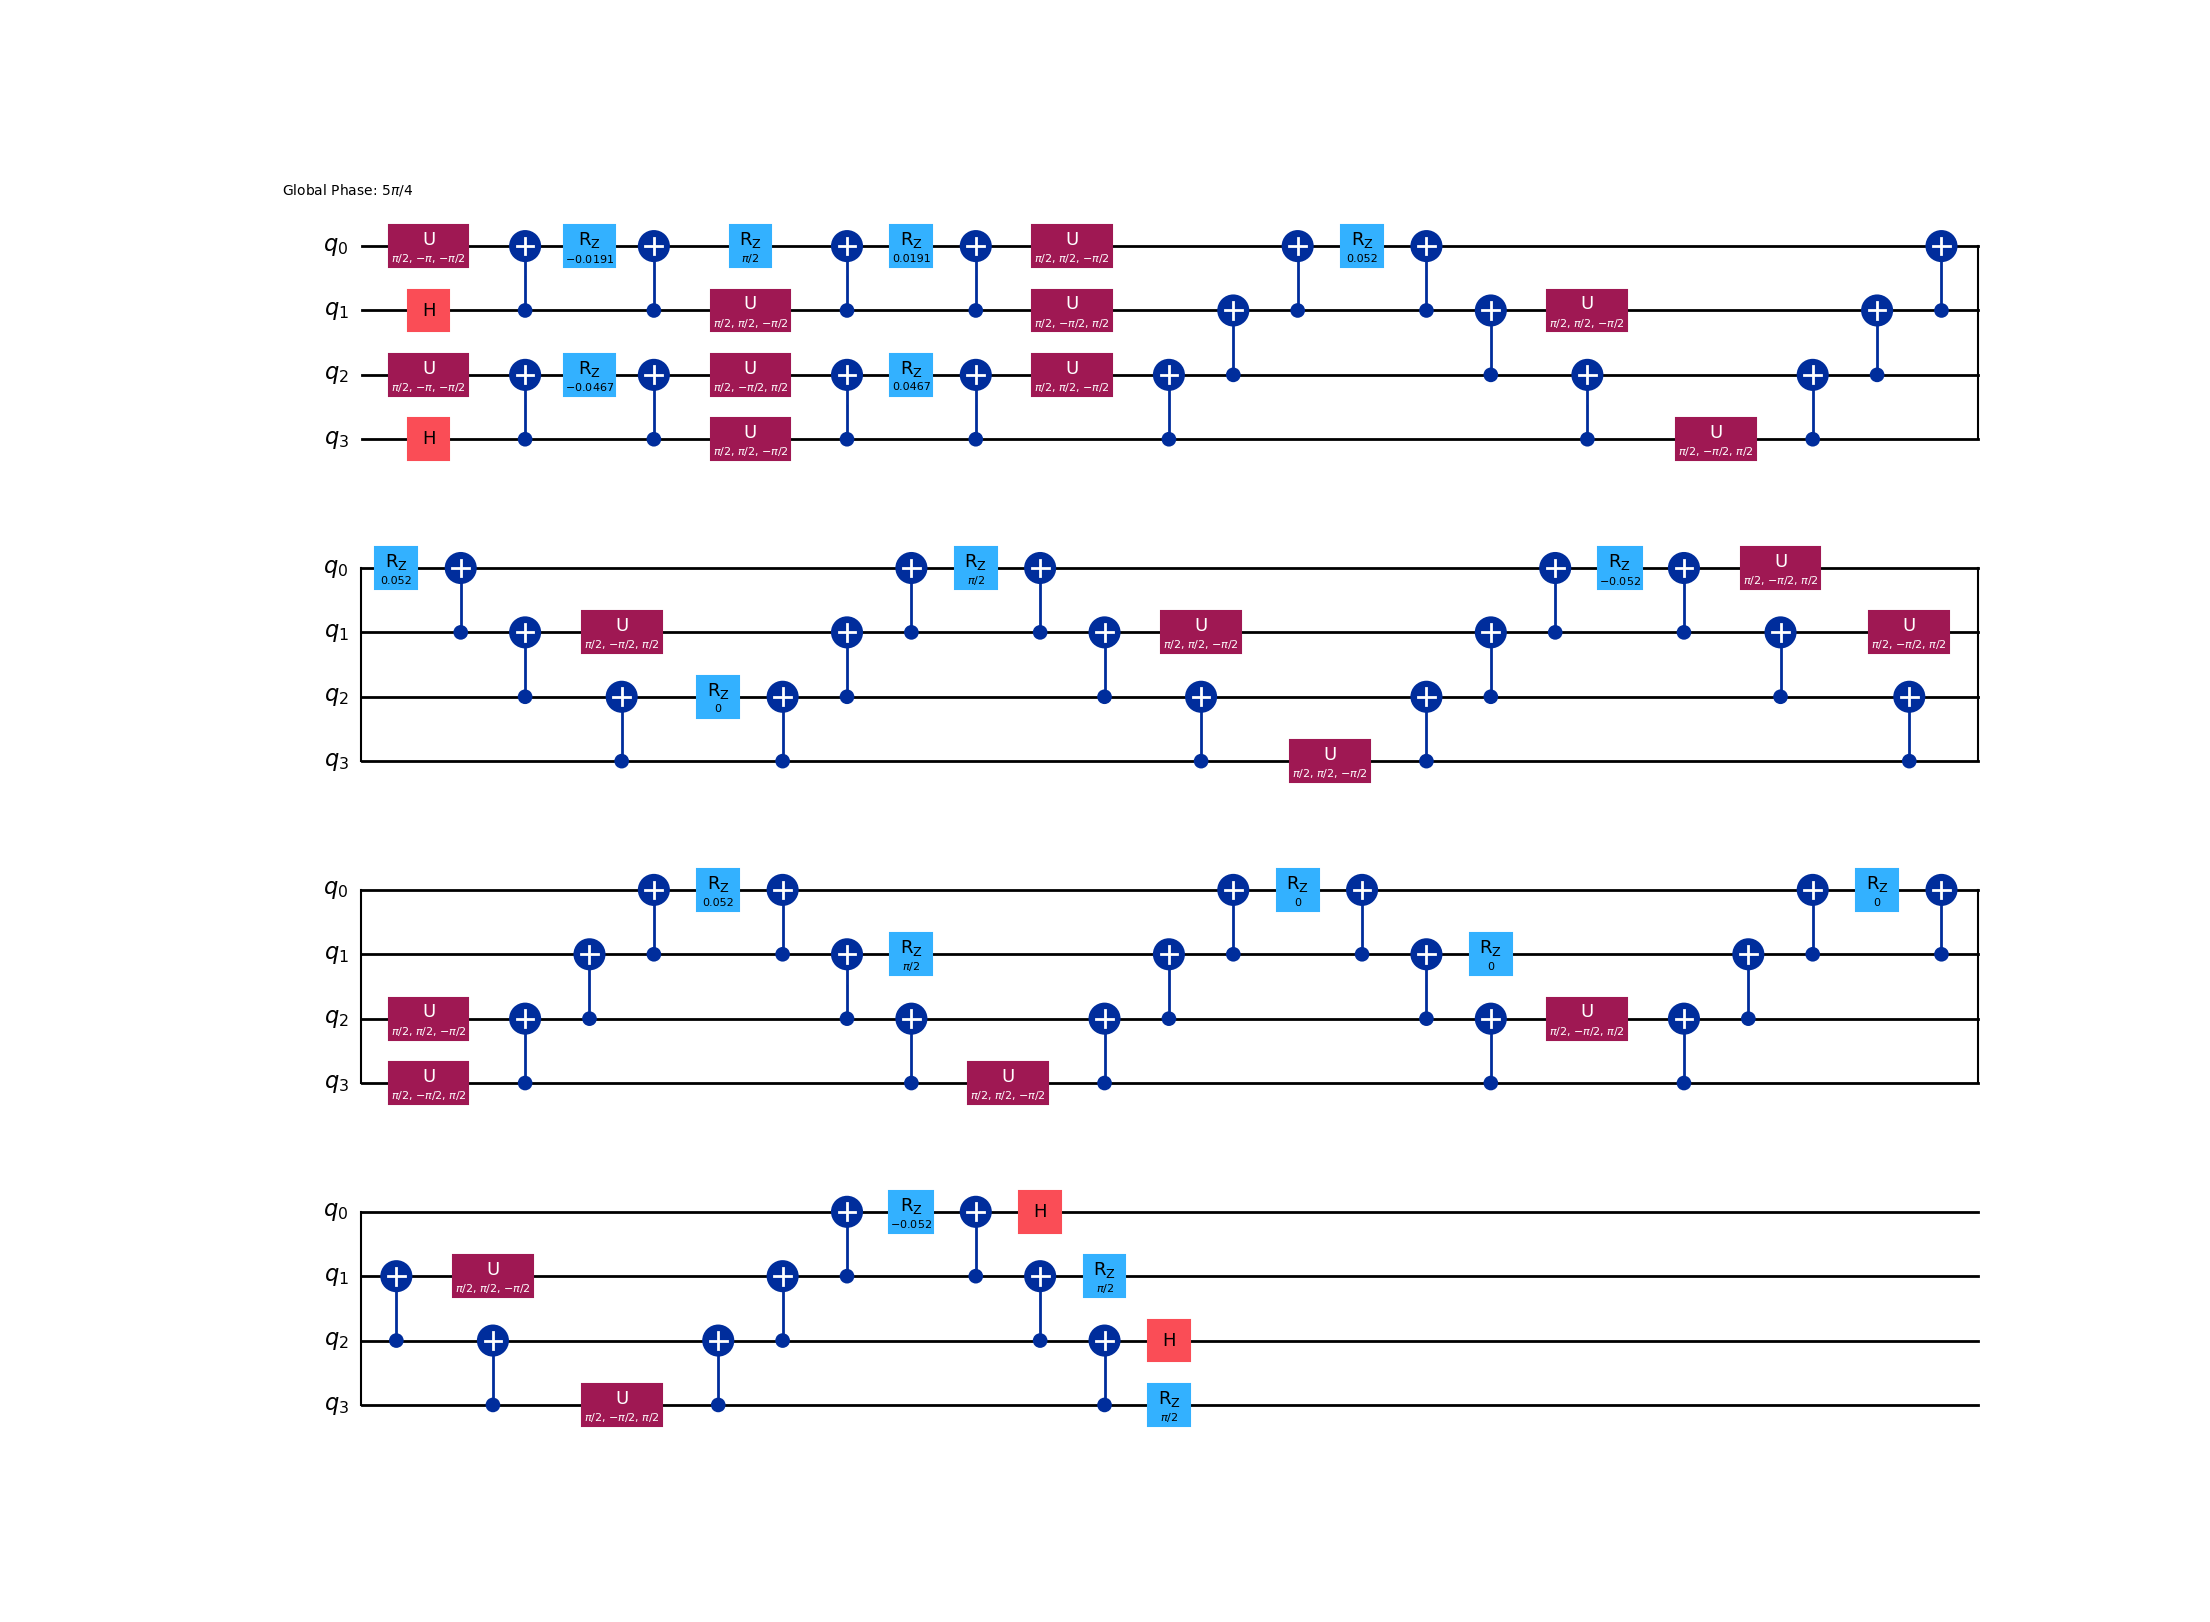

In [61]:
subs_ncg(circuito, 10).draw(output = "mpl")

In [54]:
for i, (gate, qubits, etc) in enumerate(circuito.data):
    print(gate.name, qubits)

u [Qubit(QuantumRegister(4, 'q'), 0)]
h [Qubit(QuantumRegister(4, 'q'), 1)]
cx [Qubit(QuantumRegister(4, 'q'), 1), Qubit(QuantumRegister(4, 'q'), 0)]
rz [Qubit(QuantumRegister(4, 'q'), 0)]
cx [Qubit(QuantumRegister(4, 'q'), 1), Qubit(QuantumRegister(4, 'q'), 0)]
u [Qubit(QuantumRegister(4, 'q'), 0)]
u [Qubit(QuantumRegister(4, 'q'), 1)]
cx [Qubit(QuantumRegister(4, 'q'), 1), Qubit(QuantumRegister(4, 'q'), 0)]
rz [Qubit(QuantumRegister(4, 'q'), 0)]
cx [Qubit(QuantumRegister(4, 'q'), 1), Qubit(QuantumRegister(4, 'q'), 0)]
u [Qubit(QuantumRegister(4, 'q'), 0)]
u [Qubit(QuantumRegister(4, 'q'), 1)]
u [Qubit(QuantumRegister(4, 'q'), 2)]
h [Qubit(QuantumRegister(4, 'q'), 3)]
cx [Qubit(QuantumRegister(4, 'q'), 3), Qubit(QuantumRegister(4, 'q'), 2)]
rz [Qubit(QuantumRegister(4, 'q'), 2)]
cx [Qubit(QuantumRegister(4, 'q'), 3), Qubit(QuantumRegister(4, 'q'), 2)]
u [Qubit(QuantumRegister(4, 'q'), 2)]
u [Qubit(QuantumRegister(4, 'q'), 3)]
cx [Qubit(QuantumRegister(4, 'q'), 3), Qubit(QuantumRegiste